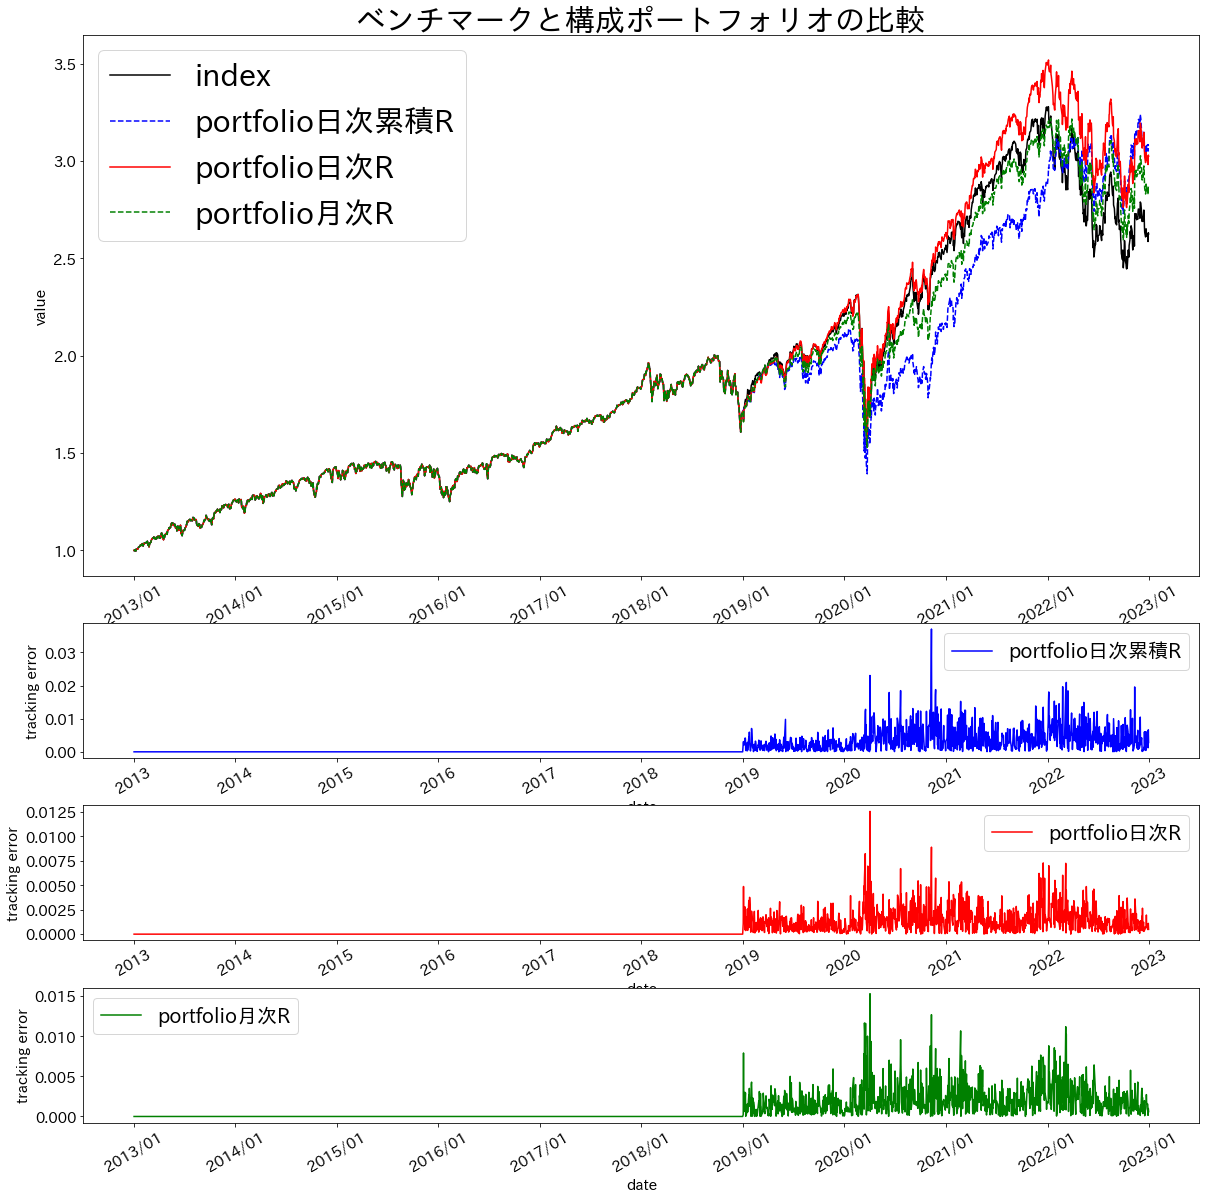

In [1]:
import os as os
import numpy as np
import scipy.stats as st
import cvxpy as cvx
import pandas as pd
import datetime
import warnings
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
warnings.filterwarnings('ignore')



tickers=pd.read_csv('tickers.csv')
tickers=tickers['ticker'].to_list()


data = pd.read_csv('./data/'+tickers[0]+'.csv')
data = data.drop(['Open', 'High','Low','Close','Adj Close','Volume'], axis=1)


for ticker in tickers:
    d = pd.read_csv('./data/'+ticker+'.csv')
    d = d.drop(['Open', 'High','Low','Adj Close','Volume'], axis=1)
    d = d.rename(columns={'Close': ticker})
    data = pd.merge(data,d,on='Date')

cal = data[['Date']]
cal['Datetime'] = pd.to_datetime(cal['Date'])
cal['year'] = cal['Datetime'].dt.year
cal['month'] = cal['Datetime'].dt.month
cal['week'] = cal['Datetime'].dt.week


cal['mon'] = 1
for index, row in cal.iterrows():
    if index > 0 and cal.iloc[index,3] != cal.iloc[index-1,3]:
        cal.iloc[index,5] = cal.iloc[index-1,5]+1
    else:
        cal.iloc[index,5] = cal.iloc[index-1,5]
        
cal['iweek'] = 1
for index, row in cal.iterrows():
    if index > 0 and cal.iloc[index,4] != cal.iloc[index-1,4]:
        cal.iloc[index,6] = cal.iloc[index-1,6]+1
    else:
        cal.iloc[index,6] = cal.iloc[index-1,6]

data = data.set_index('Date')

#月次リターンのためコピー
Rm = data

R = data.pct_change()
R = R.fillna(0)

#累積しないリターンを保存
Rd = R
R = R + 1
#累積リータン
R = R.cumprod()

Benchmark = pd.read_csv('sp500.csv')

Benchmark = Benchmark.set_index('Date')
Benchmark = Benchmark.drop(['Open', 'High','Low','Adj Close','Volume'], axis=1)



#月次リターンのためコピー
Benchmarkm = Benchmark.copy()
Benchmark = Benchmark.pct_change()
Benchmark = Benchmark.fillna(0)

Benchmarkd = Benchmark.copy()
Benchmark = Benchmark + 1
Benchmark = Benchmark.cumprod()


#配列T：縦、N：横
T = R.shape[0]
N = R.shape[1]


#------------------------------------------------
#月次リターン計算
#------------------------------------------------
r_asset = Rm.iloc[0:0]
r_index = Benchmarkm.iloc[0:0]

for i in range(120):
    if i == 0:
        start = i+1
        end = i+1
        
        startdate = cal.query('mon >= '+str(start)+' and mon <= '+str(end))['Date'].min()
        enddate = cal.query('mon >= '+str(start)+' and mon <= '+str(end))['Date'].max()
    else:
        start = i
        end = i+1
        
        startdate = cal.query('mon >= '+str(start)+' and mon <= '+str(start))['Date'].max()
        enddate = cal.query('mon >= '+str(end)+' and mon <= '+str(end))['Date'].max()
    
    r_asset = r_asset.append(Rm[enddate:enddate])
    r_index = r_index.append(Benchmarkm[enddate:enddate])
    
#print('月次データ')
#print(r_index)
    
r_asset = r_asset.pct_change()
r_asset = r_asset.fillna(0)

r_index = r_index.pct_change()
r_index = r_index.fillna(0)

# #月リターンを確認
# r_index = r_index + 1
# r_index = r_index.cumprod()

#------------------------------------------------
#月次シミュレーション
#------------------------------------------------

di = Benchmark.copy() # ポートフォリオの時価総額の推移
did = Benchmark.copy() 
dim = Benchmark.copy() 


dw = pd.DataFrame(index=R.index,columns=R.columns) # 目標配分比率の推移
di_sr = pd.DataFrame(index=R.index,columns=['Close']) # 同一比率リバランスポートフォリオの時価総額の推移
pw = pd.DataFrame(index=R.index,columns=R.columns) # 実績配分比率の推移



#最適ウェイト計算の
mon_window = 72


w_init = np.ones(N)/N
w_initd = np.ones(N)/N
w_initm = np.ones(N)/N

for i in range(120 - mon_window):

    start = 1
    end = i+mon_window
    # 計算対象の開始終了
    startdate = cal.query('mon >= '+str(start)+' and mon <= '+str(end))['Date'].min()
    enddate = cal.query('mon >= '+str(start)+' and mon <= '+str(end))['Date'].max()


    # 各資産の計算期間分のデータを取得し計算期間初からのリターンを計算
    asset = R[startdate:enddate]
    asset = asset.pct_change()
    asset = asset.fillna(0)
    asset = asset + 1
    asset = asset.cumprod()
    asset = asset.values
    
    # ベンチマークの計算期間分のデータを取得し計算期間初からのリターンを計算
    indx = Benchmark[startdate:enddate]
    indx = indx.pct_change()
    indx = indx.fillna(0)
    indx = indx + 1
    indx = indx.cumprod()
    indx = indx.values
    indx = np.squeeze(indx)

    # 最適化ソルバでウェイトを算出
    weight = cvx.Variable(N,value=w_init)
    obj = cvx.Minimize(cvx.sum_squares(asset@weight - indx))
    mintracerr = cvx.Problem(obj, [cvx.sum(weight) == 1.0,weight >= 0])
    mintracerr.solve(verbose=False)
    w = weight.value

    w[w<0]=0
    w=w/w.sum()
    w_init = w


    # 計算したウェイトと運用期間の各資産のリターンから運用期間のポートフォリオの時価評価額の比率を計算
    dstart = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].min()
    dend = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].max()
    dstartm1 = cal.query('mon >= '+str(end)+' and mon <= '+str(end))['Date'].max()


    #Backtest期間
    rtmp=R[dstartm1:dend]
        
    rtmp = rtmp.pct_change()
    rtmp = rtmp.dropna()
    rtmp = rtmp + 1
    rtmp = rtmp.cumprod()

    d = rtmp.values@w
    d = d*di.at[dstartm1,'Close']

    d = np.expand_dims(d, 1)
    di[dstart:dend]=d
    
    
    #日次リターンで最適化
    # 各資産の計算期間分のデータを取得し計算期間初からのリターンを計算
    assetd = Rd[startdate:enddate]
    Td = assetd.shape[0]
    assetd = assetd
    assetd = assetd.values
    
    # ベンチマークの計算期間分のデータを取得し計算期間初からのリターンを計算
    indxd = Benchmarkd[startdate:enddate]
    indxd = indxd
    indxd = indxd.values
    indxd = np.squeeze(indxd)

    # 最適化ソルバでウェイトを算出
    weightd = cvx.Variable(N,value=w_initd)
    objd = cvx.Minimize(cvx.sum_squares(assetd@weightd - indxd))
    mintracerrd = cvx.Problem(objd, [cvx.sum(weightd) == 1.0,weightd >= 0])
    mintracerrd.solve(verbose=False)
    wd = weightd.value

    wd[wd<0]=0
    wd=wd/wd.sum()
    w_initd = wd
        
    # 計算したウェイトと運用期間の各資産のリターンから運用期間のポートフォリオの時価評価額の比率を計算
    dstart = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].min()
    dend = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].max()
    dstartm1 = cal.query('mon >= '+str(end)+' and mon <= '+str(end))['Date'].max()

    #Backtest期間
    rtmpd=R[dstartm1:dend]
        
    rtmpd = rtmpd.pct_change()
    rtmpd = rtmpd.dropna()
    rtmpd = rtmpd + 1
    rtmpd = rtmpd.cumprod()

    dd = rtmpd.values@wd
    dd = dd*did.at[dstartm1,'Close']

    dd = np.expand_dims(dd, 1)
    did[dstart:dend]=dd
    
    
    #月次リターンで最適化
    # 各資産の計算期間分のデータを取得し計算期間初からのリターンを計算
    assetm = r_asset[startdate:enddate]    
    assetm = assetm.values


    # ベンチマークの計算期間分のデータを取得し計算期間初からのリターンを計算
    indxm = r_index[startdate:enddate]
    
    indxm = indxm.values
    indxm = np.squeeze(indxm)


    
    # 最適化ソルバでウェイトを算出
    weightm = cvx.Variable(N,value=w_initm)
    objm = cvx.Minimize(cvx.sum_squares(assetm@weightm - indxm))
    mintracerrm = cvx.Problem(objm, [cvx.sum(weightm) == 1.0,weightm >= 0])
    mintracerrm.solve(verbose=False)
    wm = weightm.value


    wm[wm<0]=0
    wm=wm/wm.sum()
    w_initm = wm
    
    #print(wd)
    
    # 計算したウェイトと運用期間の各資産のリターンから運用期間のポートフォリオの時価評価額の比率を計算
    dstart = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].min()
    dend = cal.query('mon >= '+str(end+1)+' and mon <= '+str(end+1))['Date'].max()
    dstartm1 = cal.query('mon >= '+str(end)+' and mon <= '+str(end))['Date'].max()
    
###
    rtmpm=R[dstartm1:dend]
        
    rtmpm = rtmpm.pct_change()
    rtmpm = rtmpm.dropna()
    rtmpm = rtmpm + 1
    rtmpm = rtmpm.cumprod()
    

    dm = rtmpm.values@wm
    
    dm = dm*dim.at[dstartm1,'Close']

    dm = np.expand_dims(dm, 1)
    dim[dstart:dend]=dm
    


dim1 = di[dstartm1:dstartm1].values


dw = dw.dropna()


#diの累積リターンを求める
Benchmarkm = Benchmark.copy()


import plotly.graph_objects as go
from plotly.subplots import make_subplots
ganpon=100000
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=Benchmark.index,
                         y=Benchmark['Close']*ganpon,
                         mode='lines',
                         name='SP500',
                        ), row=1, col=1
              )
fig.add_trace(go.Scatter(x=di.index,
                         y=di['Close']*ganpon,
                         mode='lines',
                         name='Portfolio',
                        ), row=1, col=1
              )
              
fig.add_trace(go.Scatter(x=r_index.index,
                         y=r_index['Close']*ganpon,
                         mode='lines',
                         name='BenchmarkMonthly',
                        ), row=1, col=1
              )
              
fig.add_trace(go.Scatter(x=Benchmark.index,
                         y=((Benchmark['Close']*ganpon-di['Close']*ganpon)**2)**0.5,
                         mode='lines',
                         name='Tracking error',
                        ), row=2, col=1
              )


Benchmark.to_csv('b2.csv')
di.to_csv('d2.csv')

import japanize_matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import dates as mdates

heights = [4, 1,1,1]
fig = plt.figure(figsize=(20, 20))
spec = fig.add_gridspec(ncols=1, nrows=4,  height_ratios=heights)
#spec = fig.add_gridspec(ncols=1, nrows=5)
ax = fig.add_subplot(spec[0, 0])

ax.plot(pd.to_datetime(Benchmark.index),Benchmark['Close'],c='k')
ax.plot(pd.to_datetime(di.index),di['Close'],c='b',linestyle="--")
ax.plot(pd.to_datetime(did.index),did['Close'],c='r',linestyle="-")
ax.plot(pd.to_datetime(dim.index),dim['Close'],c='g',linestyle="--")


ax.legend(labels=['index','portfolio日次累積R','portfolio日次R','portfolio月次R'],fontsize=30)
ax.set_xlabel('date', size=15)
ax.set_ylabel('value', size=15)
ax.set_title('ベンチマークと構成ポートフォリオの比較', fontsize=30)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=30)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))



#
#TE計算
#
portDailyCumulation = di.pct_change()
portDailyCumulation = portDailyCumulation.fillna(0)

portDaily = did.pct_change()
portDaily = portDaily.fillna(0)

portMonthly = dim.pct_change()
portMonthly = portMonthly.fillna(0)



ax = fig.add_subplot(spec[1, 0])
ax.plot(pd.to_datetime(Benchmarkm.index),((Benchmarkd['Close']-portDailyCumulation['Close'])**2)**0.5, c='b')
ax.legend(labels=['portfolio日次累積R'],fontsize=20)

ax.set_xlabel('date', size=15)
ax.set_ylabel('tracking error', size=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=30)

ax = fig.add_subplot(spec[2, 0])
ax.plot(pd.to_datetime(Benchmarkm.index),((Benchmarkd['Close']-portDaily['Close'])**2)**0.5, c='r')
ax.legend(labels=['portfolio日次R'],fontsize=20)

ax.set_xlabel('date', size=15)
ax.set_ylabel('tracking error', size=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=30)

ax = fig.add_subplot(spec[3, 0])
ax.plot(pd.to_datetime(Benchmarkm.index),((Benchmarkd['Close']-portMonthly['Close'])**2)**0.5, c= 'g')

ax.legend(labels=['portfolio月次R'],fontsize=20)

ax.set_xlabel('date', size=15)
ax.set_ylabel('tracking error', size=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(rotation=30)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m'))

fig.savefig('comparison_return_period.png')